## Dimensionality Reduction

In [20]:
import pandas as pd;
import numpy as np;
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import umap
import matplotlib.pyplot as plt

In [2]:
# Load dataset
feature_matrix = pd.read_csv("feature_engineered_survey.csv", low_memory=False)
feature_matrix

,profile_id,yearly_compensation,ml_spending,used_tpu,Total_Experience,demographics.COUNT(profileTable),demographics.MEAN(profileTable.yearly_compensation),demographics.SUM(profileTable.yearly_compensation),company.COUNT(profileTable),company.MEAN(profileTable.yearly_compensation),...,primary_tool_Cloud-based data software & APIs,primary_tool_Local development environments,primary_tool_Other,recommended_language_Other,recommended_language_Python,recommended_language_R,recommended_language_SQL,income_category_B40,income_category_M40,income_category_T20
0,0,11,2,1,4,638,11.463950,7314.0,1048,10.997137,...,False,True,False,False,True,False,False,False,False,True
1,1,15,0,0,0,902,8.657428,7809.0,352,6.738636,...,False,True,False,False,True,False,False,True,False,False
2,2,2,3,1,6,902,8.657428,7809.0,101,10.534653,...,False,True,False,False,True,False,False,False,True,False
3,3,22,0,1,8,159,7.880503,1253.0,1048,10.997137,...,False,True,False,False,True,False,False,False,False,True
4,4,0,3,0,8,158,11.063291,1748.0,986,8.873225,...,False,True,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,7794,1,3,0,6,1706,10.340563,17641.0,986,8.873225,...,False,True,False,False,True,False,False,True,False,False
7795,7795,17,3,0,4,159,7.880503,1253.0,321,10.367601,...,False,True,False,False,True,False,False,False,True,False
7796,7796,8,3,1,4,1706,10.340563,17641.0,197,10.532995,...,False,True,False,False,True,False,False,False,True,False
7797,7797,19,2,0,6,1706,10.340563,17641.0,231,10.917749,...,False,True,False,False,True,False,False,False,False,True


### Manual Reduction
Drop B40, M40, T20 income category as this standard is only in Malaysia only

In [3]:
feature_matrix.drop(columns=['income_category_B40', 'income_category_M40', 'income_category_T20'], inplace=True)

Drop id

In [4]:
feature_matrix.drop(columns=['profile_id'], inplace=True)

### Standardize Data

In [5]:
# Function to dynamically map ordinal categories
def dynamic_ordinal_mapping(df, columns):
    """
    Dynamically maps ordinal values for specified columns in a dataframe.
    Automatically assigns integer values based on the order of unique categories.

    Args:
        df (pd.DataFrame): Input dataframe.
        columns (list): List of columns to apply ordinal mapping.

    Returns:
        pd.DataFrame: Dataframe with ordinal-encoded columns.
        dict: Dictionary with column names as keys and their value-to-ordinal mappings as values.
    """
    column_mappings = {}  # To store the mappings for each column

    for col in columns:
        # Extract unique categories and sort them logically
        unique_categories = sorted(df[col].unique())
        ordinal_mapping = {category: i for i, category in enumerate(unique_categories)}
        
        # Store the mapping for the current column
        column_mappings[col] = ordinal_mapping

        # Replace categories with ordinal values
        df[col] = df[col].map(ordinal_mapping)
        
    return column_mappings, df

# Apply to ordinal columns in your dataset
ordinal_columns = [
    'company_size'
]

ordinal_map, feature_matrix = dynamic_ordinal_mapping(feature_matrix, ordinal_columns)
ordinal_map

{'company_size': {'Enterprise': 0,
  'Large': 1,
  'Medium': 2,
  'Mid-Large': 3,
  'Small': 4}}

In [6]:
# Standardize Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

### PCA

In [7]:
# Apply PCA with automatic component selection (MLE)
pca = PCA(n_components='mle')
principal_components = pca.fit_transform(scaled_features)

# Assign dynamic column names based on the number of components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96
0,-0.417714,2.408146,-1.815437,-0.902849,1.401302,1.735015,-2.195338,0.779346,0.384287,-1.094877,...,-0.053978,-0.806097,0.698346,-1.094532,-0.299492,-0.065455,-0.265647,0.014106,-0.003228,-0.037890
1,-3.998184,-2.106867,0.495669,-0.622324,0.602363,2.454301,-2.339510,0.330717,1.371669,-1.667053,...,-0.039985,0.441484,0.108762,0.337152,0.884631,-0.992318,-0.249992,0.114950,-0.084473,-0.037280
2,0.418313,-3.343614,1.702257,-0.032805,0.345381,0.476794,-1.223531,-1.252886,0.602170,-1.097313,...,-0.216603,0.735770,-0.195968,0.084956,-0.977764,-0.203348,-0.227999,-0.120748,-0.084942,-0.002612
3,3.060394,-0.984701,3.537968,1.669405,3.304366,0.608434,0.035856,0.474098,-0.257341,-0.113011,...,-1.271394,-0.472058,0.132083,0.103185,0.821887,-0.242672,0.027795,0.020603,0.076231,-0.049872
4,-1.278996,1.217529,-2.094844,1.186808,1.696778,1.673891,-1.018605,3.315003,0.855858,-0.929041,...,0.199785,0.898386,-0.555977,-1.022609,0.731784,0.333869,0.304744,-0.007232,-0.053382,0.080654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,0.805072,-4.540174,1.303718,-0.447772,-1.134086,0.443970,-0.970839,2.106019,0.472042,-0.191617,...,0.922864,-0.442875,-0.589189,0.210285,0.115500,0.365303,0.321717,0.125316,-0.033616,0.070404
7795,-1.914275,0.120852,0.514635,2.328409,3.252309,1.250278,0.607508,-0.192967,1.839199,-0.531358,...,0.153684,0.625671,-1.462083,0.757893,0.297980,-0.110660,-0.045843,-0.148573,0.065744,-0.053398
7796,0.133068,-1.143530,-1.842147,-1.091663,-1.087629,0.419689,3.770288,-0.037688,2.355171,-0.272498,...,0.514989,-0.532183,0.824316,-0.316073,-0.438338,0.053883,0.372433,-0.136750,-0.012766,-0.013982
7797,-0.240607,1.247420,-3.079762,-1.544733,0.127178,0.986453,-1.026606,-1.864893,1.189926,-1.087744,...,0.116663,1.247849,1.536181,0.556541,0.354598,-0.307357,0.266860,0.048698,-0.039189,0.075578


### t-SNE

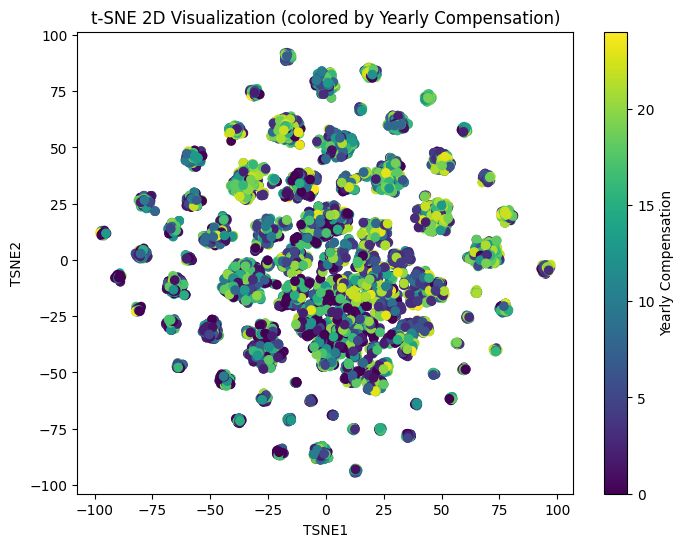

In [8]:
# --- Apply t-SNE (reduce to 2D) ---
tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2D
tsne_results = tsne.fit_transform(scaled_features)

# --- Create DataFrame for t-SNE Results ---
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

# --- Choose the target column as label for coloring ---
c = feature_matrix['yearly_compensation']  # The target column for coloring

# --- Visualize t-SNE Results ---
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=c, cmap='viridis', label='Yearly Compensation')
plt.title('t-SNE 2D Visualization (colored by Yearly Compensation)')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Yearly Compensation')
plt.show()

### UMAP

c:\Users\chunhong\program\python\data-mining-warehousing-wages-analysis\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


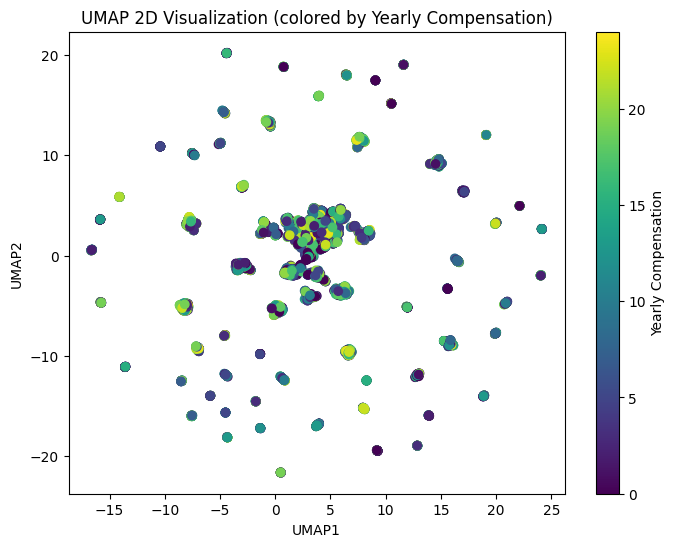

In [9]:
# --- Apply UMAP (reduce to 2D) ---
umap_model = umap.UMAP(n_components=2)
umap_results = umap_model.fit_transform(scaled_features)

# --- Create DataFrame for UMAP Results ---
umap_df = pd.DataFrame(data=umap_results, columns=['UMAP1', 'UMAP2'])

# --- Choose the target column as label for coloring ---
c = feature_matrix['yearly_compensation']  # The target column for coloring

# --- Visualize UMAP Results ---
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=c, cmap='viridis', label='Yearly Compensation')
plt.title('UMAP 2D Visualization (colored by Yearly Compensation)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Yearly Compensation')
plt.show()

### RFE

In [17]:
X = pca_df
y = feature_matrix.loc[:, "yearly_compensation"]

# Split the data into training and testing sets (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the model
model = LogisticRegression(max_iter=500)

# Create the RFE model and select the top n features
rfe = RFE(model, n_features_to_select=50)  # Set n_features_to_select as per your requirement
rfe = rfe.fit(X_train, y_train)

# Get the features selected by RFE
selected_features = rfe.support_
selected_features

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True])

In [18]:
# Evaluate the model on the test set with the selected features
X_train_rfe = X_train.iloc[:, selected_features]
X_test_rfe = X_test.iloc[:, selected_features]

model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro' / 'weighted'
recall = recall_score(y_test, y_pred, average='macro')  # or 'micro' / 'weighted'
f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro' / 'weighted'

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Accuracy: 0.7457264957264957, Precision: 0.6663183854689332, Recall: 0.649848591183082, F1-Score: 0.6503896168227853
